# Aula 11: Machine Learning Iris Dataset

## Load libraries

In [1]:
## Spark Lib
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler

from pyspark.ml.feature import PCA

#import pyarrow

## SKLearn Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import time
start_time = time.time()
%matplotlib inline

## Configure parameters

In [2]:
# Path to dataset file
data_path='/home/erick/Bases/'

# Sample of train and test dataset
train_sample = 0.7
test_sample = 0.3

## KNN using Scikit-learn

In [3]:
# Importing the dataset
dataset = pd.read_csv(data_path+"iris.csv")

# Print dataset
dataset.head(5)

,sepal length,sepal width,petal length,petal width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
print("Number of itens per class")
dataset.groupby('variety').size()

Number of itens per class


variety
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

In [5]:
# Read features and calass
feature_columns = ['sepal length', 'sepal width', 'petal length','petal width']
X = dataset[feature_columns].values
y = dataset['variety'].values

# SKLearn need all column as numbers. Tranform "class" column in number
le = LabelEncoder()
y = le.fit_transform(y)

# Split ramdomly the dataset into train and test group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_sample, random_state = 0)

<Figure size 432x288 with 0 Axes>

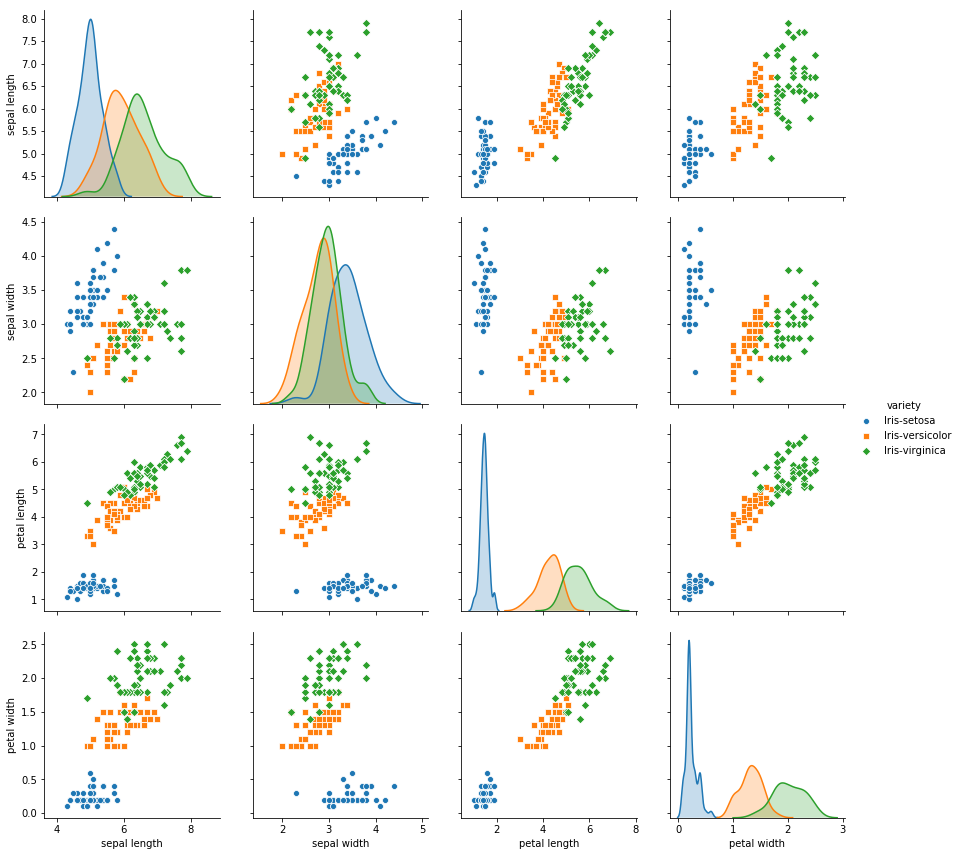

In [6]:
plt.figure()
sns.pairplot(dataset, hue = "variety", height=3, markers=["o", "s", "D"])
plt.show()

In [7]:
start_time_knn =  time.time()
# Instantiate learning model (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [8]:
accuracy_knn = accuracy_score(y_test, y_pred)*100
time_knn = time.time() - start_time_knn
print('KNN accuracy = ' + str(round(accuracy_knn, 1)) + ' %.')
print("K-Nearest Neighbors (KNN): accuracy = %3.1f %%" % accuracy_knn)
print("K-Nearest Neighbors (KNN): time = %3.3f s" % time_knn)

KNN accuracy = 97.8 %.
K-Nearest Neighbors (KNN): accuracy = 97.8 %
K-Nearest Neighbors (KNN): time = 0.021 s


## Neural network and SVM using Spark

In [9]:
# Create Spark Session
spark = SparkSession.builder \
        .master("local[8]") \
        .appName("MachineLearningIris") \
        .getOrCreate()

# Enable Arrow-based columnar data transfers
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## Reading Data

In [10]:
# Load Iris CSV dataset to Spark Dataframe
orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').\
            load(data_path+"iris.csv")

print("Original Dataframe read from CSV file")
#orig_data.dtypes
orig_data.show(5)

Original Dataframe read from CSV file
+------------+-----------+------------+-----------+-----------+
|sepal length|sepal width|petal length|petal width|    variety|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



### Create Classifier Matrix

In [11]:
# ML libraries doesn't accept string column => everything should be numeric! 
# create a numeric column "label" based on string column "class" 

indexer = StringIndexer(inputCol="variety", outputCol="label").fit(orig_data)
label_data = indexer.transform(orig_data)

# Save the inverse map from numeric "label" to string "class" to be used further in response
labelReverse = IndexToString().setInputCol("label")

# Show labeled dataframe with numeric lable
print("Dataframe with numeric lable")
label_data.show(5)

Dataframe with numeric lable
+------------+-----------+------------+-----------+-----------+-----+
|sepal length|sepal width|petal length|petal width|    variety|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
+------------+-----------+------------+-----------+-----------+-----+
only showing top 5 rows



In [12]:
# Drop string column "class", no string column
label_data = label_data.drop("variety")

# Most Machine Learning Lib inpute 2 columns: label (output) and feature (input)
# The label column is the result to train ML algorithm 
# The feature column should join all parameters as a Vector

# Set the column names that is not part of features list
ignore = ['label']
# list will be all columns parts of features
list = [x for x in label_data.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(label_data).select("label","features"))

print("Final Dataframe suitable to classifier input format")
#data.printSchema()
data.show(5)

Final Dataframe suitable to classifier input format
+-----+-----------------+
|label|         features|
+-----+-----------------+
|  0.0|[5.1,3.5,1.4,0.2]|
|  0.0|[4.9,3.0,1.4,0.2]|
|  0.0|[4.7,3.2,1.3,0.2]|
|  0.0|[4.6,3.1,1.5,0.2]|
|  0.0|[5.0,3.6,1.4,0.2]|
+-----+-----------------+
only showing top 5 rows



### Create Train and Test Dataset

In [13]:
# Split ramdomly the dataset into train and test group
# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets
# 1234 is the random seed

(train, test) = data.randomSplit([train_sample, test_sample], 1234)

## Run Perceptron

In [14]:
start_time_pr =  time.time()
# specify layers for the neural network
# parameter 1: input layer, should be the number of features
# parameter 2 and 3: the number os perceptron in two intermediate layers
# parameter 4: output layer should be the number os categories (labels)
layers = [4, 5, 5, 3]

# Create the trainer and set its parameters
# featuresCol=name_feature_column, labelCol=name_label_column
# maxIter=max_interaction, layers=list_number_perceptron 

trainer = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',\
          maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model and get the result
model = trainer.fit(train)
result_pr = model.transform(test)

print("Perceptron Final Result")
result_pr.show(5)

Perceptron Final Result
+-----+-----------------+--------------------+--------------------+----------+
|label|         features|       rawPrediction|         probability|prediction|
+-----+-----------------+--------------------+--------------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[125.163773163649...|[1.0,7.0597849525...|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[125.156306784322...|[1.0,7.1231710288...|       0.0|
|  0.0|[4.4,3.0,1.3,0.2]|[125.163112010735...|[1.0,7.0653749965...|       0.0|
|  0.0|[4.8,3.1,1.6,0.2]|[125.153911586500...|[1.0,7.1436254650...|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|[125.164148267820...|[1.0,7.0566154156...|       0.0|
+-----+-----------------+--------------------+--------------------+----------+
only showing top 5 rows



In [15]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_pr = evaluator.evaluate(result_pr) * 100
time_pr = time.time() - start_time_pr

print("Multilayer Perceptron: accuracy = %3.1f %%" % accuracy_pr)
print("Multilayer Perceptron: time = %3.3f s" % time_pr)

Multilayer Perceptron: accuracy = 97.5 %
Multilayer Perceptron: time = 6.959 s


In [16]:
print("Perceptron final result with name of class")
labelReverse.transform(result_pr).show()

Perceptron final result with name of class
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|label|         features|       rawPrediction|         probability|prediction|IndexToString_97fd5e3b060c__output|
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|  0.0|[4.3,3.0,1.1,0.1]|[125.163773163649...|[1.0,7.0597849525...|       0.0|                       Iris-setosa|
|  0.0|[4.4,2.9,1.4,0.2]|[125.156306784322...|[1.0,7.1231710288...|       0.0|                       Iris-setosa|
|  0.0|[4.4,3.0,1.3,0.2]|[125.163112010735...|[1.0,7.0653749965...|       0.0|                       Iris-setosa|
|  0.0|[4.8,3.1,1.6,0.2]|[125.153911586500...|[1.0,7.1436254650...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.5,1.6,0.6]|[125.164148267820...|[1.0,7.0566154156...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.6,1.4,0.2]|[125.164150423534...

## Run Naive Bayes

In [17]:
start_time_nb =  time.time()
# create the trainer and set its parameters
trainer = NaiveBayes(smoothing=1.0, modelType="multinomial")

#trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
#trainer = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# train the model and get the result
model = trainer.fit(train)
result_nb = model.transform(test)

In [18]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_nb = evaluator.evaluate(result_nb) * 100
time_nb = time.time() - start_time_nb

print("Naive Bayes: accuracy = %3.1f %%" % accuracy_nb)
print("Naive Bayes: time = %3.3f s" % time_nb)

Naive Bayes: accuracy = 80.0 %
Naive Bayes: time = 0.860 s


In [19]:
print("Naive Bayes Final Result")
result_nb.show()

Naive Bayes Final Result
+-----+-----------------+--------------------+--------------------+----------+
|label|         features|       rawPrediction|         probability|prediction|
+-----+-----------------+--------------------+--------------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[-9.8947865959498...|[0.73694376226986...|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[-10.798200610812...|[0.65275740620864...|       0.0|
|  0.0|[4.4,3.0,1.3,0.2]|[-10.714490841463...|[0.68253047838642...|       0.0|
|  0.0|[4.8,3.1,1.6,0.2]|[-11.685557246997...|[0.66369141823549...|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|[-13.716429687974...|[0.60272102805515...|       0.0|
|  0.0|[5.0,3.6,1.4,0.2]|[-11.987255175816...|[0.76219778414681...|       0.0|
|  0.0|[5.1,3.5,1.4,0.3]|[-12.312093126317...|[0.72926613894761...|       0.0|
|  0.0|[5.1,3.8,1.6,0.2]|[-12.662105745200...|[0.76010893715039...|       0.0|
|  0.0|[5.2,4.1,1.5,0.1]|[-12.504377655322...|[0.82613285980057...|       0.0|
|  0.0|[5.4,3.4,1.7,0.2]|[-

In [20]:
print("Naive Bayes final result with name of class")
labelReverse.transform(result_nb).show()

Naive Bayes final result with name of class
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|label|         features|       rawPrediction|         probability|prediction|IndexToString_97fd5e3b060c__output|
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|  0.0|[4.3,3.0,1.1,0.1]|[-9.8947865959498...|[0.73694376226986...|       0.0|                       Iris-setosa|
|  0.0|[4.4,2.9,1.4,0.2]|[-10.798200610812...|[0.65275740620864...|       0.0|                       Iris-setosa|
|  0.0|[4.4,3.0,1.3,0.2]|[-10.714490841463...|[0.68253047838642...|       0.0|                       Iris-setosa|
|  0.0|[4.8,3.1,1.6,0.2]|[-11.685557246997...|[0.66369141823549...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.5,1.6,0.6]|[-13.716429687974...|[0.60272102805515...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.6,1.4,0.2]|[-11.987255175816..

## Run Suport Vector Machines (SVM)

In [21]:
start_time_svm =  time.time()

# create the trainer and set its parameters
trainer = LinearSVC(featuresCol='features', labelCol='label',\
                    maxIter=100, regParam=0.1)

# LinearSVC classify ONLY in two classes
# To classify in more than 2 classes, the OneVsrest should be used
# Cloud use any kind of classifies

# instantiate the One Vs Rest Classifier.
ovr_trainer = OneVsRest(classifier=trainer)

# train the multiclass model.
model = ovr_trainer.fit(train)

# score the model on test data.
result_svm = model.transform(test)

In [22]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_svm = evaluator.evaluate(result_svm) * 100
time_svm = time.time() - start_time_nb

print("Suport Vector Machines (SVM): accuracy = %3.1f %%" % accuracy_svm)
print("Suport Vector Machines (SVM): time = %3.3f s" % time_svm)

Suport Vector Machines (SVM): accuracy = 65.0 %
Suport Vector Machines (SVM): time = 50.232 s


In [23]:
print("Suport Vector Machines (SVM) Final Result")
result_svm.show()

Suport Vector Machines (SVM) Final Result
+-----+-----------------+----------+
|label|         features|prediction|
+-----+-----------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|       0.0|
|  0.0|[4.4,3.0,1.3,0.2]|       0.0|
|  0.0|[4.8,3.1,1.6,0.2]|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|       0.0|
|  0.0|[5.0,3.6,1.4,0.2]|       0.0|
|  0.0|[5.1,3.5,1.4,0.3]|       0.0|
|  0.0|[5.1,3.8,1.6,0.2]|       0.0|
|  0.0|[5.2,4.1,1.5,0.1]|       0.0|
|  0.0|[5.4,3.4,1.7,0.2]|       0.0|
|  0.0|[5.4,3.9,1.7,0.4]|       0.0|
|  0.0|[5.5,3.5,1.3,0.2]|       0.0|
|  0.0|[5.7,3.8,1.7,0.3]|       0.0|
|  1.0|[5.0,2.3,3.3,1.0]|       1.0|
|  1.0|[5.6,2.7,4.2,1.3]|       2.0|
|  1.0|[5.6,3.0,4.5,1.5]|       2.0|
|  1.0|[5.9,3.0,4.2,1.5]|       2.0|
|  1.0|[6.0,2.9,4.5,1.5]|       2.0|
|  1.0|[6.0,3.4,4.5,1.6]|       2.0|
|  1.0|[6.1,2.8,4.7,1.2]|       2.0|
+-----+-----------------+----------+
only showing top 20 rows



## Run Decision Tree

In [24]:
start_time_dt =  time.time()

#trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
                                 
trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

#trainer = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
#                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
#                                 numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
#                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')

# train the model and get the result
model = trainer.fit(train)
result_dt = model.transform(test)

In [25]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_dt = evaluator.evaluate(result_dt) * 100
time_dt = time.time() - start_time_dt

print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt)
print("Decision Tree: time = %3.3f s" % time_dt)

Decision Tree: accuracy = 95.0 %
Decision Tree: time = 0.963 s


In [26]:
print("Decision Tree Final Result")
result_dt.show(5)

Decision Tree Final Result
+-----+-----------------+--------------+-------------+----------+
|label|         features| rawPrediction|  probability|prediction|
+-----+-----------------+--------------+-------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[4.4,3.0,1.3,0.2]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[4.8,3.1,1.6,0.2]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
+-----+-----------------+--------------+-------------+----------+
only showing top 5 rows



In [27]:
#PCA

In [28]:
def sliceFeatures(df, nValores, nomeSaidas, nomeEntrada):#dataframe / numero de colunas a serem criadas / nome das colunas de saida / ...coluna de entrada
    for i in range(nValores):
        slicer = VectorSlicer(inputCol = nomeEntrada, outputCol = nomeSaidas + str(i+1), indices=[i])
        df = slicer.transform(df)
    return df
def returnVector(df, name):#dataframe / nome da coluna , retorna um vetor da coluna especificada
    aux = np.array(df.select(name).collect())
    aux2 = []
    for i in range(df.count()):
        aux2.append(float(aux[i]))
    return aux2
def returnDimesion(nAmostras, nTipos, rangeDaMedia):#retorna um vetor np com nAmostras, com nTipos com a mesma media, que varia de 1 a rangeDaMedia 
    d = []
    for k in range(nTipo):
        t = np.random.poisson(lam=rd.randrange(1, rangeDaMedia), size = nAmostras)
        d = np.concatenate((d, t))
    return d

In [29]:
nDimensoes = 5           #dimensão dos dados (tem que ser maior que 3)
nComponentes = 4         #quantas componentes vão ser calculadas (não precisa mudar) (tem que ser maior que 3)
feature_columns = ['sepal length', 'sepal width', 'petal length','petal width']

In [30]:
#assembler = VectorAssembler(inputCols = feature_columns, outputCol="features")  # junta as colunas em uma coluna features
#data = assembler.transform(data) #aplicando a transformacao

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(data)                     #cria uma coluna scaledFeatures que é a features com media 0 e desvio padrão 1
scaledData = scalerModel.transform(data)

In [31]:
start_time_pca =  time.time()

pca = PCA(k = nComponentes, inputCol="scaledFeatures", outputCol="pcaFeatures") #cria uma coluna pcaFeatures com a imagem das amostras nas PC's 
model = pca.fit(scaledData)
result = model.transform(scaledData)

time_pca = time.time() - start_time_pca

per_var = np.round(model.explainedVariance * 100, decimals = 1)

## Sumary

In [32]:
print("==================================================================")
print("=============  Compare Algorithm Acurancy and Time ===============")
print()
print("      Train sample = ",train_sample*100,"%     Test sample = ",test_sample*100,"%")
print()
print("K-Nearest Neighbors (KNN):    accuracy = %3.1f %%   time = %3.3f s" % (accuracy_knn, time_knn))
print("Multilayer Perceptron:        accuracy = %3.1f %%   time = %3.3f s" % (accuracy_pr, time_pr))
print("Naive Bayes:                  accuracy = %3.1f %%   time = %3.3f s" % (accuracy_nb, time_nb))
print("Suport Vector Machines (SVM): accuracy = %3.1f %%   time = %3.3f s" % (accuracy_svm, time_svm))
print("Decision Tree:                accuracy = %3.1f %%   time = %3.3f s" % (accuracy_dt, time_dt))
print("Principal Component Analysis: PC1=%3.1f%% PC2=%3.1f%% time = %3.3f s" % (per_var[0], per_var[1], time_pca))
print("===================================================================")

=============  Compare Algorithm Acurancy and Time ===============

      Train sample =  70.0 %     Test sample =  30.0 %

K-Nearest Neighbors (KNN):    accuracy = 97.8 %   time = 0.021 s
Multilayer Perceptron:        accuracy = 97.5 %   time = 6.959 s
Naive Bayes:                  accuracy = 80.0 %   time = 0.860 s
Suport Vector Machines (SVM): accuracy = 65.0 %   time = 50.232 s
Decision Tree:                accuracy = 95.0 %   time = 0.963 s
Principal Component Analysis: PC1=72.8% PC2=23.0% time = 0.313 s


In [33]:
spark.stop()
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 75.57973432540894 seconds ---
